In [1]:
using LinearAlgebra
using PolyChaos
using QuadGK
using Plots
using Base.Threads

println(Threads.nthreads())


function SpectralFunc(input::AbstractString, D::Float64, g::Float64)
    inband = x -> (-D <= x <= D)
        
    if input == "flat"
        J = x -> inband(x) ? 1/(2D) : 0.0
    elseif input == "elliptical"
        J = x -> inband(x) ? sqrt(1 - (x/D)^2) : 0.0
    elseif input == "ohmic"
        J = x -> inband(x) ? abs(x) : 0.0
    elseif input == "lorentzian"
        J = x -> 1/(1 + (x/D)^2)
    else
        error("spectral function type not recognized")
    end
    # normalization
    norm = quadgk(J, -D, D)[1]           
    Jnorm = x -> g*D/pi * J(x) / norm
    return Jnorm
end

function ThermofieldTransform(J, beta::Float64, mu::Float64) #spectral function, inverse temp, chemical potential
    """thermofield purification using fermi function ancilla"""
    fermi(k) = 1/(1 + exp(beta*k - beta*mu))
    J1 = w -> J(w) * fermi(w) #filled mode spectral density
    J2 = w -> J(w) * (1 - fermi(w)) #empty mode spectral density
    return J1, J2
end

function ChainMap(J, N::Int64, D::Float64)
    """calculates family of monic orthogonal polynomials w.r.t the measure J(x) up to the Nth term.
    returns the coefficients alpha and beta from the recurrence relation of the family."""
    supp = (-D, D)
    meas = Measure("bath", J, supp, false, Dict())
    ortho_poly = OrthoPoly("bath_op", N, meas; Nquad=100000)   
    chain = coeffs(ortho_poly)                                  
    Es = chain[1:N,1] #site energies
    ts = sqrt.(chain[1:N,2]) #site hoppings (first term is system hopping)
    return Es, ts
end

function PrepareCorrs(N, sys_occ)                
    
    I_L  = I(N)                
    Z_L  = zeros(N, N)

    # assemble C0
    C0 = zeros(ComplexF64, 2N+1, 2N+1)
    C0[N+1,N+1] = sys_occ + 0im
    C0[1:N, 1:N] .= I_L    
    C0[N+2:end, N+2:end] .= Z_L
    C0 = Hermitian(C0)
    return C0
end


function HamiltonianCorrs(N::Int64, Es::Float64, E1, h1, E2, h2)
"""exact Hamiltonian for chain mapped OQS"""
    E1 = reverse(E1) #empty chain onsite energies
    h1 = reverse(h1) #empty chain NN couplings
    d = Vector{Float64}(undef, 2*N+1)     # diagonal 
    e = Vector{Float64}(undef, 2*N)       # off-diagonal
    d[1:N] .= E1
    d[N+1] = Es
    d[N+2:2N+1] .= E2
    e[1:N] .= h1
    e[N+1:2N] .= h2
    H = SymTridiagonal(d, e)            # Hermitian and tridiagonal
    return H
end

function EvolveCorrs(C0, H, dt, N)
    Cs = Vector{Array{ComplexF64}}(undef, 0)
    C0 = Matrix(C0)
    H = Matrix(H)
    
    # Pre-compute the single step propagator
    U_dt = exp(-im * dt * H) 
    U_dt_dag = U_dt'
    
    C_curr = C0
    push!(Cs, C_curr)
    
    step = 1
    ans = false
    
    while ans == false 
        # Update state iteratively
        C_curr = U_dt * C_curr * U_dt_dag
        push!(Cs, C_curr)
        
        if step % 100 == 0
            nSys = [real(M[N+1,N+1]) for M in Cs[end-100:end]]
            min,max = extrema(nSys)
            ans = (max-min < 0.0001)
        end
        step += 1
        # Safety break to prevent infinite loops if it doesn't settle
        if step > 2000; break; end 
    end
    return Cs
end

"""
    EvaluatePolynomials(omega, Es, ts)
Evaluates the orthonormal polynomials p_n(omega) up to order N-1.
Returns a vector [p_0, p_1, ..., p_{N-1}].
"""
function EvaluatePolynomials(omega::Float64, Es::Vector{Float64}, ts::Vector{Float64})
    N = length(Es)
    p = zeros(Float64, N)
    
    # Base case: p_0 = 1 / beta_0
    # ts[1] corresponds to the system-chain coupling (beta_0)
    if abs(ts[1]) < 1e-12
        return p 
    end
    p[1] = 1.0 / ts[1]
    
    if N == 1; return p; end

    # Recurrence relation:
    # beta_{n} * p_{n} = (omega - alpha_{n-1}) * p_{n-1} - beta_{n-1} * p_{n-2}
    # Mapping to 1-based indexing:
    # ts[n+1] * p[n+1] = (omega - Es[n]) * p[n] - ts[n] * p[n-1]
    
    # First step (p[2] which is p_1)
    p[2] = (omega - Es[1]) * p[1] / ts[2]
    
    for n in 2:N-1
        p[n+1] = ((omega - Es[n]) * p[n] - ts[n] * p[n-1]) / ts[n+1]
    end
    
    return p
end

"""
    CalculateSpectra(C, E1, h1, E2, h2, omegas, J_func, beta, mu)

Inverts the Thermofield chain mapping to recover n(omega) from the correlation matrix C.
Handles the specific index layout: [Reverse(Chain1), System, Forward(Chain2)].
"""
function CalculateSpectra(
    C::Matrix{ComplexF64}, 
    E1::Vector{Float64}, h1::Vector{Float64}, 
    E2::Vector{Float64}, h2::Vector{Float64}, 
    omegas::Vector{Float64}, 
    J_func::Function, beta::Float64, mu::Float64
)
    n_w = zeros(Float64, length(omegas))
    N = length(E1)
    
    # Indices for the sub-blocks (Based on your Hamiltonian layout)
    # Chain 1: 1 to N (Reversed)
    idx1 = 1:N
    # Chain 2: N+2 to 2N+1 (Forward)
    idx2 = (N+2):(2*N+1)
    
    # Extract sub-matrices once
    C11 = C[idx1, idx1]
    C22 = C[idx2, idx2]
    C12 = C[idx1, idx2] # Cross terms
    
    fermi(w) = 1.0 / (1.0 + exp(beta * (w - mu)))
    
    Threads.@threads for k in 1:length(omegas)
        w = omegas[k]
        J_val = J_func(w)
        
        # Only compute if spectral density is significant
        if abs(J_val) > 1e-12
            f = fermi(w)
            
            # --- 1. Evaluate Polynomials ---
            P1 = EvaluatePolynomials(w, E1, h1)
            P2 = EvaluatePolynomials(w, E2, h2)
            
            # --- 2. Construct Projection Vectors (Correct Indexing) ---
            
            # Vector for Chain 1 (Reverse Order: p_0 is at index N, p_{N-1} at index 1)
            Psi1 = zeros(Float64, N)
            for i in 1:N
                # P1[1] is p_0. It goes to the site connected to system (End of block)
                Psi1[N + 1 - i] = P1[i]
            end
            
            # Vector for Chain 2 (Forward Order: p_0 is at index 1, p_{N-1} at index N)
            Psi2 = zeros(Float64, N)
            for i in 1:N
                # P2[1] is p_0. It goes to site connected to system (Start of block)
                Psi2[i] = P2[i]
            end
            
            # --- 3. Compute Normalized Occupations per Chain ---
            
            # Norms (LDOS) - Denominators
            norm1 = dot(Psi1, Psi1)
            norm2 = dot(Psi2, Psi2)
            
            # Occupations (Raw) - Numerators
            occ1_raw = real(dot(Psi1, C11 * Psi1))
            occ2_raw = real(dot(Psi2, C22 * Psi2))
            
            # Safe Division
            n1 = (norm1 > 1e-12) ? (occ1_raw / norm1) : 0.0
            n2 = (norm2 > 1e-12) ? (occ2_raw / norm2) : 0.0
            
            # --- 4. Cross Term (Coherence) ---
            # Normalized by geometric mean of norms
            coherence_raw = dot(Psi1, C12 * Psi2) # Complex
            n12 = 0.0
            if (norm1 > 1e-12) && (norm2 > 1e-12)
                n12 = real(coherence_raw) / sqrt(norm1 * norm2)
            end
            
            # --- 5. Combine with Thermofield Weights ---
            # The physical weights are f and (1-f)
            term_chain1 = f * n1
            term_chain2 = (1.0 - f) * n2
            term_cross  = 2.0 * sqrt(f * (1.0 - f)) * n12
            
            n_w[k] = term_chain1 + term_chain2 + term_cross
        else
            n_w[k] = 0.0
        end
    end
    
    return n_w
end

8


CalculateSpectra

In [2]:
N=100
g = 0.5
beta = 100.0
mu = 0.0
D=1.0

Es = 0.0
dt = 0.1

J = SpectralFunc("elliptical", D, g)
J1, J2 = ThermofieldTransform(J, beta, mu)
E1, h1 = ChainMap(J1, N, D)
E2, h2 = ChainMap(J2, N, D)
C0 = PrepareCorrs(N, 0.4) 
H = HamiltonianCorrs(N, Es, E1, h1, E2, h2)
Cs = EvolveCorrs(C0, H, dt, N)

201-element Vector{Array{ComplexF64}}:
 [1.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 - 0.0im 1.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; … ; 0.0 - 0.0im 0.0 - 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 - 0.0im 0.0 - 0.0im … 0.0 - 0.0im 0.0 + 0.0im]
 [1.0000000000000004 + 0.0im 0.0 - 1.0408340855860843e-17im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 1.0408340855860843e-17im 1.0000000000000007 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; … ; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im]
 [1.0000000000000009 - 6.938893903907228e-18im 4.336808689942018e-19 - 2.7755575615628914e-17im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 2.7755575615628914e-17im 1.0000000000000013 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; … ; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im]
 [1.0000000000000013 - 6.938893903907228e-18im 8.673617379884035e-19 - 5.204170427930421e-17im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 5.204170427930421e-17im 1.00000

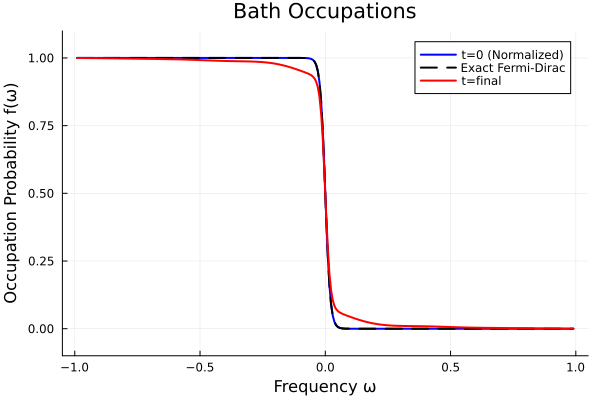

In [3]:
# Use a grid strictly inside [-D, D] to avoid floating point edge issues
omegas = collect(range(-0.99, 0.99, length=300))

# Calculate
n_init = CalculateSpectra(Cs[1], E1, h1, E2, h2, omegas, J, beta, mu)
n_final = CalculateSpectra(Cs[end], E1, h1, E2, h2, omegas, J, beta, mu)

# Plot
using Plots
plot(omegas, n_init, label="t=0 (Normalized)", lw=2, color=:blue)
plot!(omegas, [1.0/(1+exp(beta*(w-mu))) for w in omegas], 
      label="Exact Fermi-Dirac", ls=:dash, color=:black, lw=2)
plot!(omegas, n_final, label="t=final", lw=2, color=:red)

xlabel!("Frequency ω")
ylabel!("Occupation Probability f(ω)")
title!("Bath Occupations")
ylims!(-0.1, 1.1) # Set limits to see the [0,1] bound

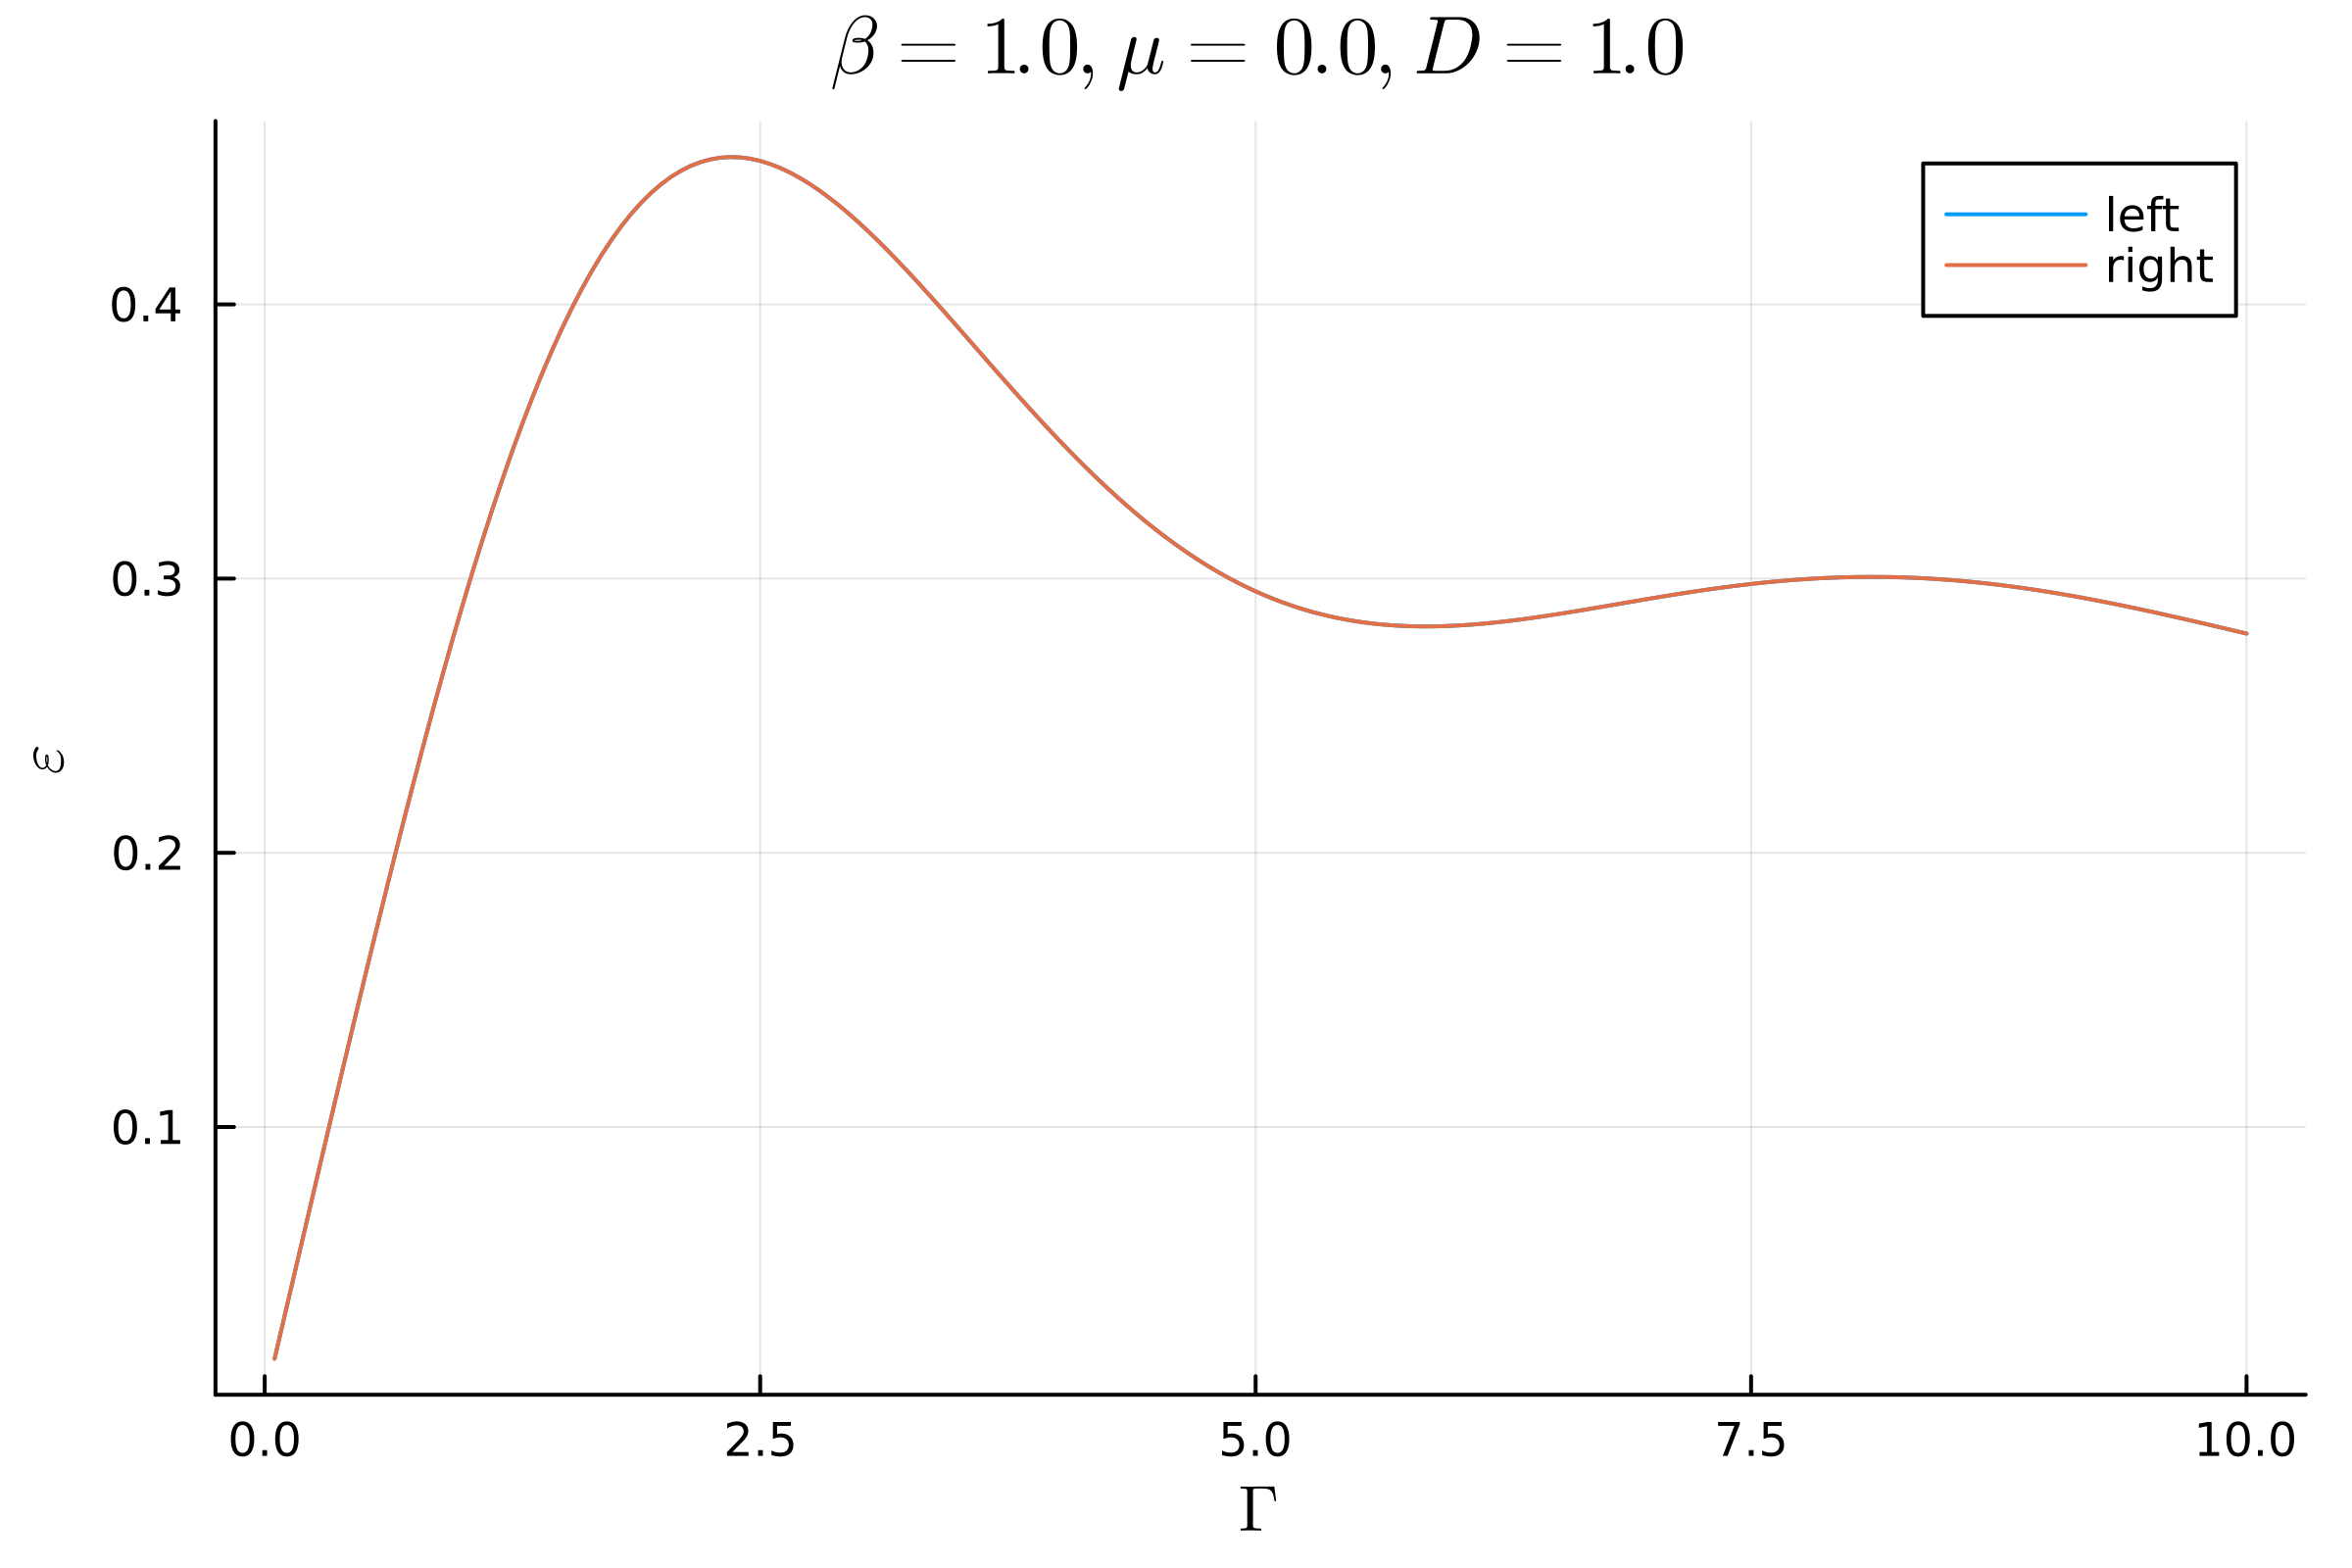

In [9]:
D = 1.0
beta = 1.0
mu = 0.0


gs = collect(0.05:0.05:10.0)
eps_L = zeros(length(gs))
eps_R = zeros(length(gs))
for (i,g) in enumerate(gs)
    J = SpectralFunc("elliptical", D, g)
    J1, J2 = ThermofieldTransform(J, beta, mu)
    E1, h1 = ChainMap(J1, N, D)
    E2, h2 = ChainMap(J2, N, D)
    C0 = PrepareCorrs(N, 0.5) 
    H = HamiltonianCorrs(N, Es, E1, h1, E2, h2)
    Cs = EvolveCorrs(C0, H, dt, N)
    Cend = Cs[end]
    eps_L[i] = 1.0 - real(Cend[N-1, N-1])
    eps_R[i] = real(Cend[N+3, N+3])
end

p = plot(gs, eps_L, xlabel="\$\\Gamma\$", ylabel="\$\\varepsilon\$",title="\$\\beta=$beta,\\mu=$mu,D=$D\$", label="left")
plot!(gs, eps_R, label="right", dpi=400)

display(p)